# Australia Data Jobs - Exploratory Data Analysis

### Summary & Insights

* An extract of 2.7K jobs advertised in Australia on Linkedin were analysed (sourced from Kaggle).

* This was reduced to 837 due to a focus on jobs with the titles:
    * Data Scientist (487)
    * Data Engineer  (124)
    * Data Analyst   (226)
    
    
* The ave. salary per title is:
    * Data Scientist:   100K
    * Data Engineering: 115K
    * Data Analyst:     118K
    
    
* The top 3 skills across all 3 data jobs are SQL, Python and R.

# Set up notebook

importing packages and configuring pandas to show all rows

In [9]:
import numpy as np
import pandas as pd
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

read csv inputs csv & convert to dataframes

In [11]:
file1 = r'/kaggle/input/australia-data-science-jobs/AustraliaDataScienceJobs.csv'
file2 = r'/kaggle/input/australia-data-science-jobs/AustraliaDataScienceJob2.csv'

# Re-importing datasets and checking for data issues
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the datasets
df = pd.concat([df1, df2])

# sample the dataframe
df.sample(3)

,Job Title,Job Location,Company,Url,Estimate Base Salary,Low Estimate,High Estimate,Company Size,Company Type,Company Sector,...,cassandra_yn,hive_yn,bigml_yn,tableau_yn,powerbi_yn,nlp_yn,pytorch_yn,tensorflow_yn,mathematic_yn,statistic_yn
261,Food Technologist,Reservoir,Taouk Enterprises Pty Ltd,https://www.glassdoor.com.au/partner/jobListin...,75000,70000,80000,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
420,Mobile Engineer,Surfers Paradise,"Anonyome Labs, Inc.",https://www.glassdoor.com.au/partner/jobListin...,111394,83000,140000,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
734,Research Assistant,Melbourne,Murdoch Childrens Research Institute,https://www.glassdoor.com.au/partner/jobListin...,88625,80000,97000,1001 to 5000 Employees,Non-profit Organisation,Non-profit & NGO,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print("Total jobs " + str(df.shape[0]))

Total jobs 2740


# Keep job titles to either 1) Data Analyst 2) Data Engineer 3) Data Scientist

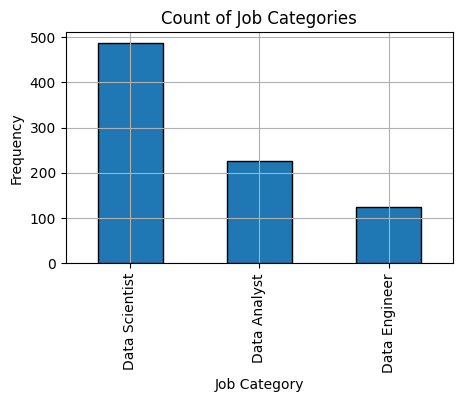

In [13]:
# Checking for non-string values in 'Job Title' column
df['Job Title'] = df['Job Title'].astype(str)

# Define the categories and their possible titles
categories = {
    "Data Analyst": ["data analyst"],
    "Data Engineer": ["data engineer"],
    "Data Scientist": ["data scientist"]
}

def classify_job_title(title):
    title_lower = title.lower()
    for category, terms in categories.items():
        for term in terms:
            if term in title_lower:
                return category
    return "Other Analyst"

# Apply function to classify job titles
df['Job Category'] = df['Job Title'].apply(classify_job_title)

# only keep job titles if they are 1 of the 3 labels
df = df[df['Job Category'].isin(['Data Scientist','Data Analyst','Data Engineer'])]

# Plotting the count of each job category
plt.figure(figsize=(5, 3))
df['Job Category'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Count of Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Top Salary by Job

In [14]:
# Calculate average salary and count per job category
average_salary_count = df.groupby('Job Category')['Estimate Base Salary'].agg(['mean', 'count']).reset_index()
average_salary_count.columns = ['Job Category', 'Average Salary', 'Job Count']

# Format the output to make it prettier
average_salary_count['Average Salary'] = average_salary_count['Average Salary'].apply(lambda x: f"${x:,.2f}")

print(average_salary_count)

     Job Category Average Salary  Job Count
0    Data Analyst     $99,805.35        226
1   Data Engineer    $115,013.54        124
2  Data Scientist    $118,312.09        487


# Top skills mentioned in job

In [15]:
# Extract skill columns
skill_columns = [col for col in df.columns if col.endswith('_yn')]

# Calculate skill percentages per job category
skill_percentages = df.groupby('Job Category')[skill_columns].mean() * 100
skill_percentages = skill_percentages.reset_index()

# Rename columns
skill_percentages.columns = ['Job Category'] + [col.replace('_yn', '') for col in skill_percentages.columns if col != 'Job Category']

# Round percentages to 2 decimal places
skill_percentages = skill_percentages.round(2)

# Calculate the average percentage of times each skill is mentioned across all roles
average_skill_percentage = skill_percentages.iloc[:, 1:].mean(axis=1).round(2)
skill_percentages['Average'] = average_skill_percentage

# Transpose the data to have job titles as columns and skills as rows
skill_percentages_pivot = skill_percentages.set_index('Job Category').transpose()

# Add the average column to the transposed data
skill_percentages_pivot['Average'] = skill_percentages_pivot.mean(axis=1).round(2)

# Sort the output in descending order by the new "Average" column
sorted_skill_percentages_pivot = skill_percentages_pivot.sort_values(by='Average', ascending=False)

# Drop the "Average" column
sorted_skill_percentages_pivot = sorted_skill_percentages_pivot.drop(index='Average')

# Limit to the top 10 rows
top_10_skills = sorted_skill_percentages_pivot.head(10)

# Function to highlight top 3 values per column
def highlight_top3(s):
    s_numeric = pd.to_numeric(s, errors='coerce')
    is_top3 = s_numeric >= s_numeric.nlargest(3).min()
    return ['background-color: yellow' if v else '' for v in is_top3]

# Apply the highlight function to each job category column
styled_pivot = top_10_skills.style.apply(highlight_top3, subset=top_10_skills.columns)

# Replace 0 values with empty strings for display after highlighting
styled_pivot = styled_pivot.format(lambda x: '' if x == 0 else x)

# Display the result
styled_pivot

Job Category,Data Analyst,Data Engineer,Data Scientist,Average
sql,79.65,62.1,82.96,74.9
python,72.12,35.48,69.4,59.0
r,40.71,11.29,60.16,37.39
mathematic,15.93,14.52,42.92,24.46
tableau,26.11,9.68,31.62,22.47
statistic,19.03,5.65,41.48,22.05
aws,19.03,25.81,14.99,19.94
excel,26.99,8.06,9.03,14.69
powerbi,18.58,4.84,13.35,12.26
spark,20.8,6.45,6.16,11.14


# Salary and Job count by Company 

In [17]:
# Calculate average salary and count per company
company_salary_count = df
company_salary_count = company_salary_count.groupby('Company')['High Estimate'].agg(['mean', 'count']).reset_index()
company_salary_count.columns = ['Company', 'Average Salary', 'Job Count']

# Sort by Average Salary
company_salary_count = company_salary_count.sort_values(by='Average Salary', ascending=False).reset_index(drop=True)

mean_salary = company_salary_count['Average Salary'].mean()
std_dev_salary = company_salary_count['Average Salary'].std()

# Calculate the number of standard deviations each company is from the mean
company_salary_count['SDs from Ave. Salary'] = company_salary_count['Average Salary'].apply(lambda x: (x - mean_salary) / std_dev_salary)

# Sort by Average Salary
company_salary_count = company_salary_count.sort_values(by='Average Salary', ascending=False).reset_index(drop=True)

# Format the Average Salary column after sorting
company_salary_count['Average Salary'] = company_salary_count['Average Salary'].apply(lambda x: f"${int(x):,}")

pd.concat([company_salary_count.head(5),company_salary_count.tail(5)])

,Company,Average Salary,Job Count,SDs from Ave. Salary
0,Capgemini,"$201,000",1,2.743168
1,Neospot Pty Ltd,"$195,000",27,2.514001
2,Blue Bison Recruitment,"$190,000",3,2.323029
3,Super Retail Group,"$187,000",1,2.208446
4,Davidson Recruitment,"$180,000",1,1.941085
121,Finecast,"$90,000",2,-1.496411
122,Prospection Pty,"$80,000",1,-1.878355
123,Accountancy Options,"$65,000",1,-2.451271
124,Hearts & Science,"$64,000",22,-2.489466
125,Kmart,"$64,000",24,-2.489466


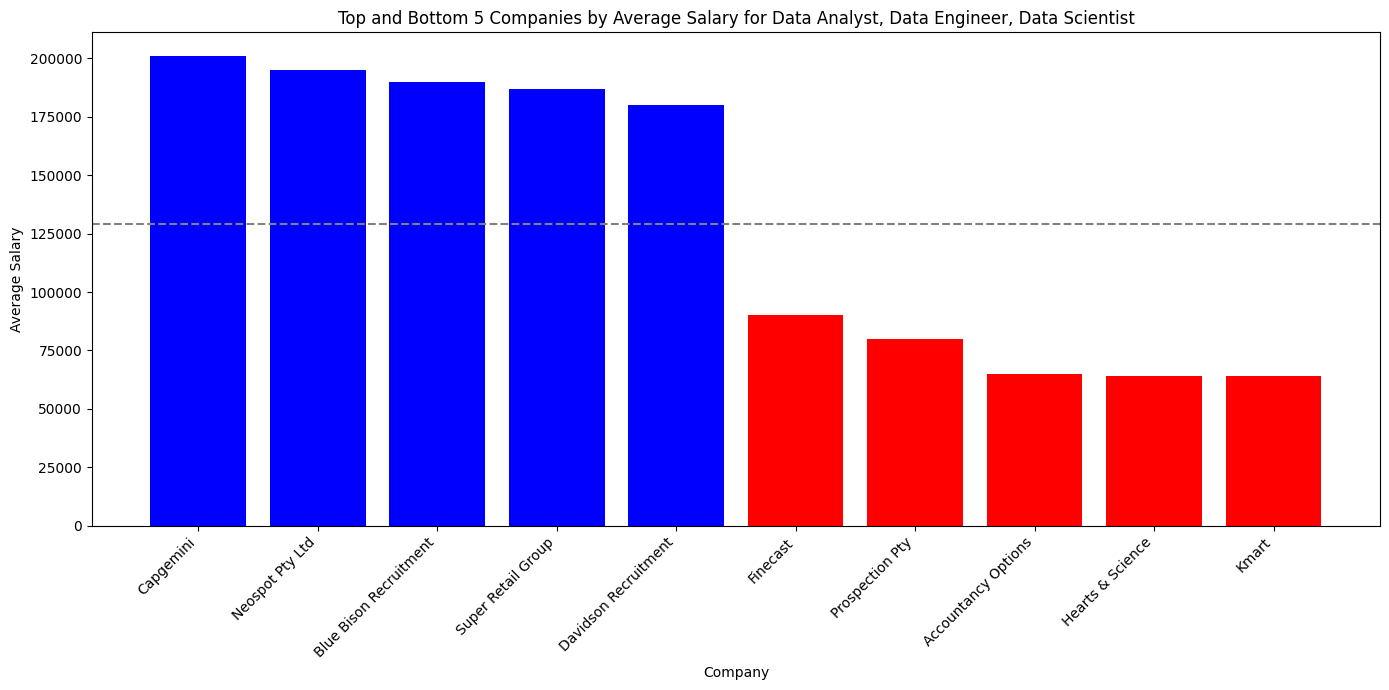

In [18]:
def analyze_salaries(df, job_categories):
    # Filter the DataFrame by job categories
    category_df = df[df['Job Category'].isin(job_categories)]
    
    # Calculate average salary and count per company
    company_salary_count = category_df.groupby('Company')['High Estimate'].agg(['mean', 'count']).reset_index()
    company_salary_count.columns = ['Company', 'Average Salary', 'Job Count']

    # Sort by Average Salary
    company_salary_count = company_salary_count.sort_values(by='Average Salary', ascending=False).reset_index(drop=True)

    # Calculate the overall mean and standard deviation
    mean_salary = company_salary_count['Average Salary'].mean()
    std_dev_salary = company_salary_count['Average Salary'].std()

    # Calculate the number of standard deviations each company is from the mean
    company_salary_count['Std Dev from Mean'] = company_salary_count['Average Salary'].apply(lambda x: (x - mean_salary) / std_dev_salary)

    return company_salary_count

def plot_combined_top_bottom_salaries(df, job_categories):
    salary_data = analyze_salaries(df, job_categories)
    top_5 = salary_data.head(5)
    bottom_5 = salary_data.tail(5)
    combined = pd.concat([top_5, bottom_5])
    
    plt.figure(figsize=(14, 7))
    plt.bar(combined['Company'], combined['Average Salary'], color=['blue']*5 + ['red']*5)
    plt.axhline(y=salary_data['Average Salary'].mean(), color='gray', linestyle='--')
    plt.title(f"Top and Bottom 5 Companies by Average Salary for {', '.join(job_categories)}")
    plt.xlabel("Company")
    plt.ylabel("Average Salary")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
# List of job categories
job_categories = ['Data Analyst', 'Data Engineer', 'Data Scientist']

# Plot for combined job categories
plot_combined_top_bottom_salaries(df, job_categories)

## Full Salary Data by Company

In [19]:
company_salary_count

,Company,Average Salary,Job Count,SDs from Ave. Salary
0,Capgemini,"$201,000",1,2.743168
1,Neospot Pty Ltd,"$195,000",27,2.514001
2,Blue Bison Recruitment,"$190,000",3,2.323029
3,Super Retail Group,"$187,000",1,2.208446
4,Davidson Recruitment,"$180,000",1,1.941085
5,Nearmap,"$179,000",1,1.902891
6,AMP Limited,"$173,000",12,1.673724
7,Schlumberger,"$171,000",5,1.597335
8,Alinta Energy,"$171,000",1,1.597335
9,Edrolo,"$170,000",4,1.559141
